# Socio-economic Impact on Green Jobs: An EDA Approach

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
import scipy.stats as stats
from scipy.stats import pearsonr
from scipy.stats import shapiro, kstest, normaltest, kruskal, friedmanchisquare, mannwhitneyu
import scikit_posthocs as sp
from statsmodels.nonparametric.kernel_regression import KernelReg

In [3]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder

In [4]:
# Set visual display settings
sns.set(style='whitegrid')

In [5]:
# load csv
original_df = pd.read_csv('complete_renewable_energy_dataset 2.csv')

In [6]:
original_df.head()

,Country,Year,Energy Type,Production (GWh),Installed Capacity (MW),Investments (USD),Population,GDP,Energy Consumption,Energy Exports,...,Economic Freedom Index,Ease of Doing Business,Innovation Index,Number of Research Institutions,Number of Renewable Energy Conferences,Number of Renewable Energy Publications,Energy Sector Workforce,Proportion of Energy from Renewables,Public-Private Partnerships in Energy,Regional Renewable Energy Cooperation
0,USA,2011,Solar,85404.690027,5549.794323,5.604125e+09,1064007213,1.775278e+14,369654.644184,93087.198199,...,49.216800,57.678605,76.803228,851,75,6361,511658,25.907895,1,0
1,Australia,2008,Geothermal,22205.069382,43211.593798,6.361886e+08,1033255852,6.435372e+13,771781.636293,1752.536054,...,79.990942,1.761579,48.697825,590,39,9752,974948,95.003547,0,1
2,Canada,2013,Biomass,94102.732038,6139.117212,6.158680e+09,14895124,1.567926e+14,342707.152899,65146.592498,...,94.374040,77.657334,67.334813,101,7,311,326318,67.354539,1,0
3,Japan,2010,Biomass,88771.932910,40323.639260,8.526116e+09,1448827283,1.350464e+14,498839.574253,50257.591014,...,65.143472,44.987734,4.544289,327,3,7708,506078,33.754104,0,0
4,China,2018,Solar,93288.408581,30755.403056,5.086237e+09,1499494307,8.677956e+13,819064.362785,63101.395562,...,86.213626,62.535223,10.287199,985,69,4919,187964,59.509228,1,0


In [7]:
# Vars

# specify numeric columns
numeric_columns = original_df.select_dtypes(include=['int64', 'float64']).columns

# specify columns to eliminate
columns_to_exclude = ['transaction_id', 'customer_id', 'product_id']

# columns for usual numeric process
cols_to_process = ['GDP', 'Renewable Energy Jobs', 'Innovation Index', 
                      'Industrialization Rate', 'Production (GWh)', 'Educational Level']

num_cols = original_df[cols_to_process].columns.tolist()

# filter out the specified numeric columns
filtered_numeric_columns = [col for col in numeric_columns if col not in columns_to_exclude]


# Create a copy of the original DataFrame
original_df_copy = original_df.copy()

## Data Cleaning

No NAN or duplicate rows detected

### Test For Outliers

In [8]:
def count_outliers_iqr(dataframe, columns):
    outlier_counts = {}
    for column in columns:
        # Calculate Q1 (25th percentile) and Q3 (75th percentile)
        Q1 = dataframe[column].quantile(0.25)
        Q3 = dataframe[column].quantile(0.75)
        IQR = Q3 - Q1
        
        # Define the outlier boundaries
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Count the outliers
        outliers = dataframe[(dataframe[column] < lower_bound) | (dataframe[column] > upper_bound)]
        outlier_counts[column] = outliers.shape[0]  # Number of outliers
    
    return outlier_counts

# Count outliers in the specified numeric columns
outlier_counts = count_outliers_iqr(original_df, cols_to_process)

print(f"Number of outliers in total_amount column: {outlier_counts}")

Number of outliers in total_amount column: {'GDP': 0, 'Renewable Energy Jobs': 0, 'Innovation Index': 0, 'Industrialization Rate': 0, 'Production (GWh)': 0, 'Educational Level': 0}


### Test for Normality

In [9]:
# Shapiro-Wilk test for Normality
def shapiroWilk(df, columns):
    for col in columns:
        stat, p = shapiro(df[col])
        print(f'Shapiro-Wilk Test for {col}: Statistics={stat}, p-value={p}')
        
        if p > 0.05:
            print(f'{col} looks Gaussian (fail to reject H0)')
        else:
            print(f'{col} does not look Gaussian (reject H0)')

testNormalityShapiro = shapiroWilk(original_df, cols_to_process)

print(testNormalityShapiro)

Shapiro-Wilk Test for GDP: Statistics=0.9517573670282636, p-value=5.97407640850402e-28
GDP does not look Gaussian (reject H0)
Shapiro-Wilk Test for Renewable Energy Jobs: Statistics=0.9551794862532815, p-value=4.66511043724896e-27
Renewable Energy Jobs does not look Gaussian (reject H0)
Shapiro-Wilk Test for Innovation Index: Statistics=0.9561281180748943, p-value=8.423698819151487e-27
Innovation Index does not look Gaussian (reject H0)
Shapiro-Wilk Test for Industrialization Rate: Statistics=0.9547025405283093, p-value=3.4785284064980525e-27
Industrialization Rate does not look Gaussian (reject H0)
Shapiro-Wilk Test for Production (GWh): Statistics=0.9558008302416663, p-value=6.862530276922458e-27
Production (GWh) does not look Gaussian (reject H0)
Shapiro-Wilk Test for Educational Level: Statistics=0.9553830746610175, p-value=5.2916128340740634e-27
Educational Level does not look Gaussian (reject H0)
None


In [10]:
original_df.shape

(2500, 56)

### Data Transformation & Scaling

In [11]:
# Data Transformation (Square Root Transformation)
original_df_copy[num_cols] = original_df_copy[num_cols].apply(lambda x: np.sqrt(x) if x.min() >= 0 else np.sqrt(np.abs(x)))

In [12]:
# Normalization

# Normalizing numerical columns
scaler = StandardScaler()

original_df_copy[num_cols] = scaler.fit_transform(original_df_copy[num_cols])

# Display the normalized DataFrame
original_df_copy[num_cols].head()

,GDP,Renewable Energy Jobs,Innovation Index,Industrialization Rate,Production (GWh),Educational Level
0,1.150261,0.864260,0.880586,-1.526703,1.152837,0.453332
1,-0.437410,1.307001,0.123455,-0.514179,-0.818491,-1.653374
2,0.910017,0.418321,0.643965,-1.459820,1.352698,-0.263955
3,0.640288,-2.450482,-1.931896,-1.051761,1.231364,0.053749
4,-0.050072,-0.849483,-1.475746,0.001650,1.334390,-2.767298


In [13]:
testNormalityShapiro = shapiroWilk(original_df_copy, num_cols)

Shapiro-Wilk Test for GDP: Statistics=0.9405393178054223, p-value=1.4329469171942872e-30
GDP does not look Gaussian (reject H0)
Shapiro-Wilk Test for Renewable Energy Jobs: Statistics=0.9506811801578934, p-value=3.2035601704531137e-28
Renewable Energy Jobs does not look Gaussian (reject H0)
Shapiro-Wilk Test for Innovation Index: Statistics=0.9424042319090022, p-value=3.660757994415505e-30
Innovation Index does not look Gaussian (reject H0)
Shapiro-Wilk Test for Industrialization Rate: Statistics=0.9482210336104803, p-value=8.009919306660761e-29
Industrialization Rate does not look Gaussian (reject H0)
Shapiro-Wilk Test for Production (GWh): Statistics=0.9528403039458055, p-value=1.130656624723221e-27
Production (GWh) does not look Gaussian (reject H0)
Shapiro-Wilk Test for Educational Level: Statistics=0.9488763193622601, p-value=1.1528835514292518e-28
Educational Level does not look Gaussian (reject H0)


### Visualizing Non-normality

In [14]:
def qqplot(df):
    variables = df.columns
    # Calculate the number of rows needed
    n_vars = len(variables)
    n_cols = 2
    n_rows = (n_vars + n_cols - 1) // n_cols

    # Create a figure with subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6, n_rows * 3))

    # Flatten the axes array for easy iteration
    axes = axes.flatten()

    # Plot Q-Q plots for each variable
    for i, var in enumerate(variables):
        sm.qqplot(df[var], line='45', ax=axes[i])
        axes[i].set_title(f'Q-Q Plot for {var}')

    # Remove any empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout
    plt.tight_layout()
    plt.show()

In [15]:
original_df.head()

,Country,Year,Energy Type,Production (GWh),Installed Capacity (MW),Investments (USD),Population,GDP,Energy Consumption,Energy Exports,...,Economic Freedom Index,Ease of Doing Business,Innovation Index,Number of Research Institutions,Number of Renewable Energy Conferences,Number of Renewable Energy Publications,Energy Sector Workforce,Proportion of Energy from Renewables,Public-Private Partnerships in Energy,Regional Renewable Energy Cooperation
0,USA,2011,Solar,85404.690027,5549.794323,5.604125e+09,1064007213,1.775278e+14,369654.644184,93087.198199,...,49.216800,57.678605,76.803228,851,75,6361,511658,25.907895,1,0
1,Australia,2008,Geothermal,22205.069382,43211.593798,6.361886e+08,1033255852,6.435372e+13,771781.636293,1752.536054,...,79.990942,1.761579,48.697825,590,39,9752,974948,95.003547,0,1
2,Canada,2013,Biomass,94102.732038,6139.117212,6.158680e+09,14895124,1.567926e+14,342707.152899,65146.592498,...,94.374040,77.657334,67.334813,101,7,311,326318,67.354539,1,0
3,Japan,2010,Biomass,88771.932910,40323.639260,8.526116e+09,1448827283,1.350464e+14,498839.574253,50257.591014,...,65.143472,44.987734,4.544289,327,3,7708,506078,33.754104,0,0
4,China,2018,Solar,93288.408581,30755.403056,5.086237e+09,1499494307,8.677956e+13,819064.362785,63101.395562,...,86.213626,62.535223,10.287199,985,69,4919,187964,59.509228,1,0


In [16]:
original_df_copy.head()

,Country,Year,Energy Type,Production (GWh),Installed Capacity (MW),Investments (USD),Population,GDP,Energy Consumption,Energy Exports,...,Economic Freedom Index,Ease of Doing Business,Innovation Index,Number of Research Institutions,Number of Renewable Energy Conferences,Number of Renewable Energy Publications,Energy Sector Workforce,Proportion of Energy from Renewables,Public-Private Partnerships in Energy,Regional Renewable Energy Cooperation
0,USA,2011,Solar,1.152837,5549.794323,5.604125e+09,1064007213,1.150261,369654.644184,93087.198199,...,49.216800,57.678605,0.880586,851,75,6361,511658,25.907895,1,0
1,Australia,2008,Geothermal,-0.818491,43211.593798,6.361886e+08,1033255852,-0.437410,771781.636293,1752.536054,...,79.990942,1.761579,0.123455,590,39,9752,974948,95.003547,0,1
2,Canada,2013,Biomass,1.352698,6139.117212,6.158680e+09,14895124,0.910017,342707.152899,65146.592498,...,94.374040,77.657334,0.643965,101,7,311,326318,67.354539,1,0
3,Japan,2010,Biomass,1.231364,40323.639260,8.526116e+09,1448827283,0.640288,498839.574253,50257.591014,...,65.143472,44.987734,-1.931896,327,3,7708,506078,33.754104,0,0
4,China,2018,Solar,1.334390,30755.403056,5.086237e+09,1499494307,-0.050072,819064.362785,63101.395562,...,86.213626,62.535223,-1.475746,985,69,4919,187964,59.509228,1,0


### Visualizing the Data Distribution

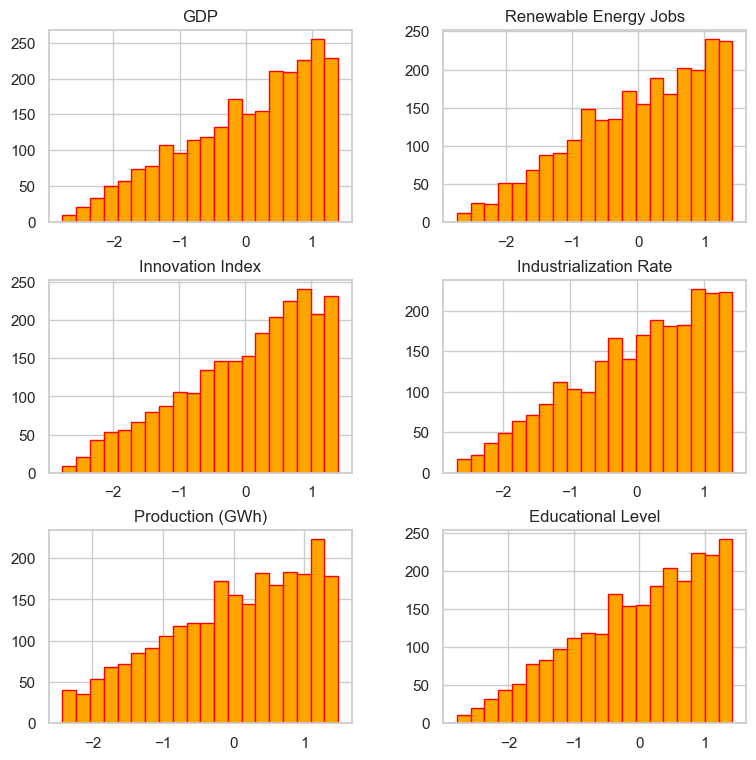

In [34]:
# Histogram for all numerical features
original_df_copy[num_cols].hist(figsize=(9, 9), bins=20, color='orange', edgecolor='red')
plt.show()

## Linear Regression

In [26]:
# Define the dependent and independent variables
X = original_df[['GDP', 'Innovation Index','Industrialization Rate', 'Educational Level', 'Production (GWh)']]
y = original_df['Renewable Energy Jobs']

# Add a constant to the independent variables
X = sm.add_constant(X)

# Fit the OLS model
model = sm.OLS(y, X).fit()

# Get the residuals
residuals = model.resid

# Print the summary of the regression
print(model.summary())

                              OLS Regression Results                             
Dep. Variable:     Renewable Energy Jobs   R-squared:                       0.008
Model:                               OLS   Adj. R-squared:                  0.006
Method:                    Least Squares   F-statistic:                     3.873
Date:                   Sat, 05 Oct 2024   Prob (F-statistic):            0.00169
Time:                           07:25:38   Log-Likelihood:                -34953.
No. Observations:                   2500   AIC:                         6.992e+04
Df Residuals:                       2494   BIC:                         6.995e+04
Df Model:                              5                                         
Covariance Type:               nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------

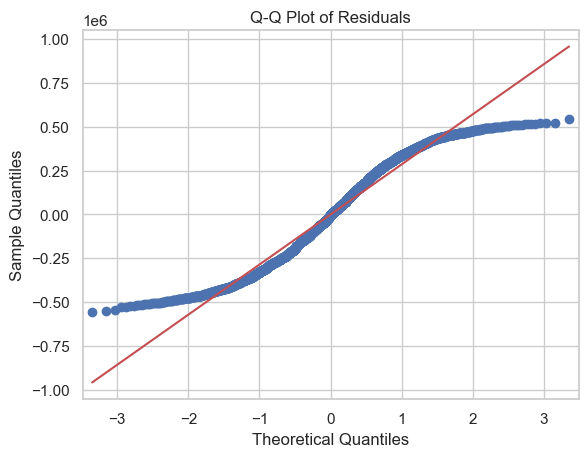

In [21]:
# Plot a Q-Q plot of the Residual
sm.qqplot(residuals, line='s')
plt.title('Q-Q Plot of Residuals')
plt.show()

### Test the Normality of the Residual

In [39]:
shapiro_test = shapiro(residuals)
print(f"Shapiro-Wilk Test: W={shapiro_test[0]}, p-value={shapiro_test[1]}")

Shapiro-Wilk Test: W=0.9593056706211436, p-value=6.5645635257839e-26


### Plotting the Regression

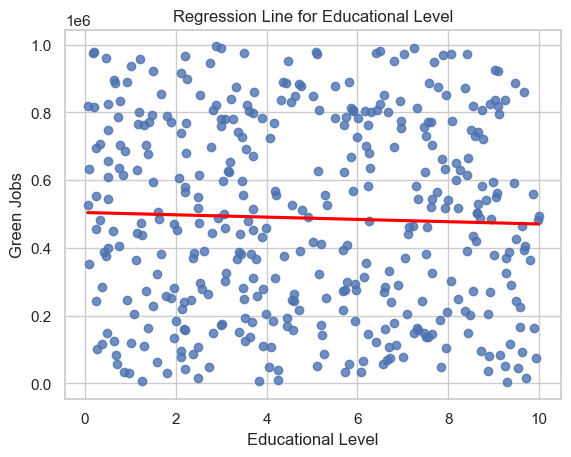

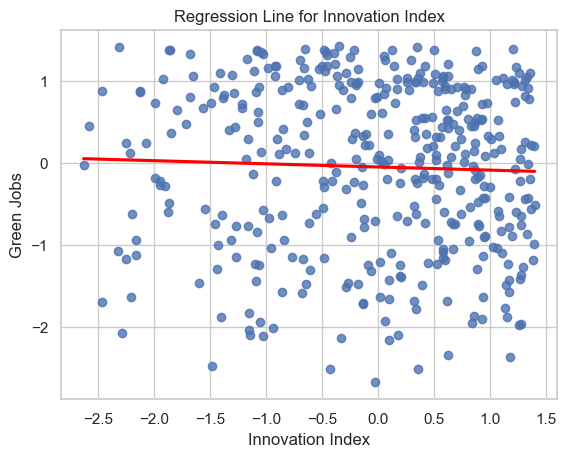

In [37]:
# For Innovation Index (Independent Variables) and Renewable Energy Jobs (Green Jobs) as dependent variable
sampled_df = original_df_copy.sample(n=400, random_state=42) 
# Plotting the regression line for one of the features
sns.regplot(x='Innovation Index', y='Renewable Energy Jobs', data=sampled_df, ci=None, line_kws={"color": "red"})
plt.xlabel('Innovation Index')
plt.ylabel('Green Jobs')
plt.title('Regression Line for Innovation Index')
plt.show()

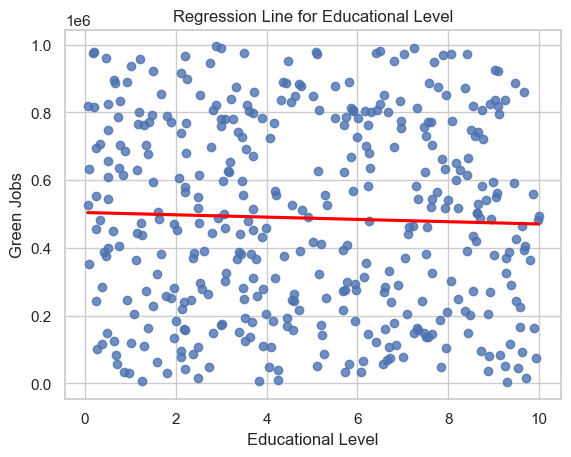

In [36]:
# For Educational Level (Independent Variables) and Renewable Energy Jobs (Green Jobs) as dependent variable
# Plotting the regression line for one of the features
sns.regplot(x='Educational Level', y='Renewable Energy Jobs', data=sampled_df, ci=None, line_kws={"color": "red"})
plt.xlabel('Educational Level')
plt.ylabel('Green Jobs')
plt.title('Regression Line for Educational Level')
plt.show()

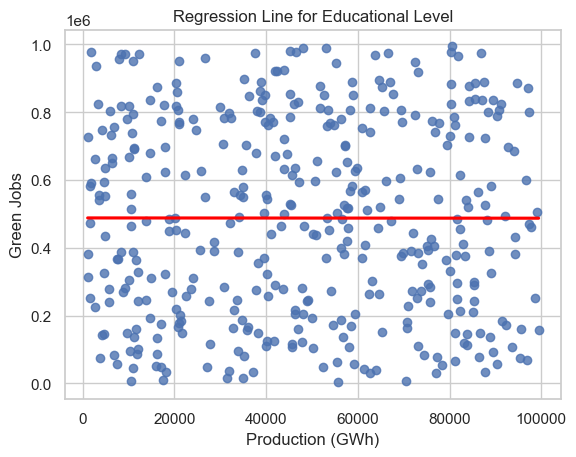

In [35]:
# For Production (Independent Variables) and Renewable Energy Jobs (Green Jobs) as dependent variable
# Plotting the regression line for one of the features
sns.regplot(x='Production (GWh)', y='Renewable Energy Jobs', data=sampled_df, ci=None, line_kws={"color": "red"})
plt.xlabel('Production (GWh)')
plt.ylabel('Green Jobs')
plt.title('Regression Line for Educational Level')
plt.show()